In [ ]:
import pandas_datareader as pdr
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM


 We will train this LSTM network using Tesla's stock market data

In [ ]:
df=pdr.get_data_tiingo('TSLA',api_key=key)

In [ ]:
df.to_csv('Tesla.csv')

In [ ]:
data=pd.read_csv('Tesla.csv')

In [ ]:
data

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,TSLA,2016-12-02 00:00:00+00:00,181.47,184.8800,180.0000,182.88,4042324,36.294,36.9760,36.0000,36.576,20211620,0.0,1.0
1,TSLA,2016-12-05 00:00:00+00:00,186.80,188.8900,182.5100,182.51,4072239,37.360,37.7780,36.5020,36.502,20361195,0.0,1.0
2,TSLA,2016-12-06 00:00:00+00:00,185.85,186.5800,182.6825,185.52,3391622,37.170,37.3160,36.5365,37.104,16958110,0.0,1.0
3,TSLA,2016-12-07 00:00:00+00:00,193.15,193.4000,185.0000,186.15,5461851,38.630,38.6800,37.0000,37.230,27309255,0.0,1.0
4,TSLA,2016-12-08 00:00:00+00:00,192.29,192.5000,189.5400,192.05,3194148,38.458,38.5000,37.9080,38.410,15970740,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,TSLA,2021-11-23 00:00:00+00:00,1109.03,1180.4999,1062.7000,1167.51,36171700,1109.030,1180.4999,1062.7000,1167.510,36171700,0.0,1.0
1253,TSLA,2021-11-24 00:00:00+00:00,1116.00,1132.7700,1062.0000,1080.39,22560238,1116.000,1132.7700,1062.0000,1080.390,22560238,0.0,1.0
1254,TSLA,2021-11-26 00:00:00+00:00,1081.92,1108.7827,1081.0000,1099.47,11680890,1081.920,1108.7827,1081.0000,1099.470,11680890,0.0,1.0
1255,TSLA,2021-11-29 00:00:00+00:00,1136.99,1142.6700,1100.1900,1100.99,19464467,1136.990,1142.6700,1100.1900,1100.990,19464467,0.0,1.0


In [ ]:
# We will consider only the closing price of the stock after 
data1=data.reset_index()["close"]

In [ ]:
data1.shape

(1257,)

In [ ]:
# Getting the data in the range of (0,1) using Min max scaler as LSTMS are sensitive to large input values
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [ ]:
# as u can see the  data has been converted to an array
data1

array([[0.00121372],
       [0.00380138],
       [0.00334016],
       ...,
       [0.43837206],
       [0.46510792],
       [0.46888017]])

In [ ]:
#We will make a 75:25 train test split 
training_size=int(len(data1)*0.75)
test_size=len(data1)-training_size
train_data,test_data=data1[0:training_size,:],data1[training_size:len(data1),:1]

In [ ]:
train_data.shape,test_data.shape

((942, 1), (315, 1))

In [ ]:
#Definig the Function to create training set and test set 
def create_dataset(dataset, time_step):
	data_X, data_Y = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]  
		data_X.append(a)
		data_Y.append(dataset[i + time_step, 0])
	return np.array(data_X), np.array(data_Y)

In [ ]:
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [ ]:
#An LSTM needs 3 inputs 
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
#Creating a model with 3 LSTM layers 
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) #Layer with 50 activation units
model.add(LSTM(50,return_sequences=True))  #Layer with 50 activation units
model.add(LSTM(65)) #Layer with 65 activation units
model.add(Dense(1))
#Specifying the type of loss and the optimizing Algorithm
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
#Summary of the model 
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 65)                30160     
                                                                 
 dense_1 (Dense)             (None, 1)                 66        
                                                                 
Total params: 60,826
Trainable params: 60,826
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=10,verbose=1)

Epoch 1/100
85/85 [==============================] - 12s 142ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 2/100
85/85 [==============================] - 11s 128ms/step - loss: 0.0014 - val_loss: 0.0075
Epoch 3/100
85/85 [==============================] - 11s 127ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 4/100
85/85 [==============================] - 11s 127ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 5/100
85/85 [==============================] - 11s 127ms/step - loss: 9.8566e-04 - val_loss: 0.0061
Epoch 6/100
85/85 [==============================] - 11s 127ms/step - loss: 0.0012 - val_loss: 8.4651e-04
Epoch 7/100
85/85 [==============================] - 11s 126ms/step - loss: 6.6617e-04 - val_loss: 7.0593e-04
Epoch 8/100
85/85 [==============================] - 11s 126ms/step - loss: 8.1895e-04 - val_loss: 7.4996e-04
Epoch 9/100
85/85 [==============================] - 11s 127ms/step - loss: 6.1234e-04 - val_loss: 6.6368e-04
Epoch 10/100
85/85 [==============================

In [ ]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [ ]:
#Scaling the predicting data back to the original range 
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
# Getting the error in our predictions 
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

529.4482758441019
758.7435851046544


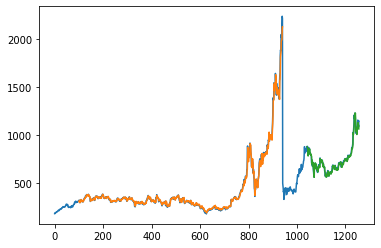

In [ ]:
### Plotting 
# Green indicates test predictions , Blue indicates original data,orange indicates train predictions.
look_back=100
trainPredictPlot = np.empty_like(data1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data1)-1, :] = test_predict
# plot the original stock graph  and  the train and test predictions 
plt.plot(scaler.inverse_transform(data1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
X_input=test_data[215:].reshape(1,-1)
X_input.shape

(1, 100)

In [ ]:
temp_input=list(X_input)
temp_input=temp_input[0].tolist()

In [ ]:
# demonstrate prediction for next 30 days

output=[] #List to store output of price over next 30 days
n_steps=100
i=0
while(i<30):
    #After the first prediction
    if(len(temp_input)>100) :
        X_input=np.array(temp_input[1:])
        print(f"{i} day input {X_input}")
        X_input=X_input.reshape(1,-1)
        X_input = X_input.reshape((1, n_steps, 1))
        yhat = model.predict(X_input, verbose=0)
        print(f"{i} day output {yhat}")
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        output.extend(yhat.tolist())
        i=i+1
    else:
        X_input = X_input.reshape((1, n_steps,1))
        yhat = model.predict(X_input, verbose=0)
        #First Prediction
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        output.extend(yhat.tolist())
        i=i+1
    



[0.46471715]
101
1 day input [0.23768072 0.23032071 0.22897106 0.22587364 0.22684461 0.23377739
 0.231248   0.2283205  0.22546583 0.23237919 0.22614551 0.22721359
 0.24195788 0.24673994 0.25764888 0.25768286 0.25825574 0.2600569
 0.25251726 0.25963452 0.25780423 0.25675072 0.26375632 0.26129004
 0.24623989 0.23630679 0.24760897 0.24007418 0.24337065 0.25601278
 0.257076   0.25839167 0.25351737 0.25874122 0.26796066 0.27029586
 0.26950451 0.26867918 0.26925206 0.27864626 0.27910748 0.27958811
 0.27056288 0.27383021 0.27455359 0.28005904 0.2806222  0.28183592
 0.26760139 0.27207275 0.27817048 0.27899582 0.28906971 0.29730845
 0.29060871 0.29242929 0.28959889 0.28947266 0.2925361  0.29207974
 0.29312839 0.2984008  0.29445863 0.29759003 0.30428007 0.30688229
 0.31039723 0.32239365 0.33554069 0.33270543 0.33344823 0.34713901
 0.35475148 0.41067007 0.40754838 0.41698143 0.43600287 0.45394654
 0.49986892 0.48210488 0.50242744 0.51021954 0.50642302 0.47770636
 0.41000981 0.43158978 0.42943421 

In [ ]:
#prediction for next 30 days in the form of a list 
output

[[0.46471714973449707],
 [0.47254395484924316],
 [0.4779561460018158],
 [0.48449158668518066],
 [0.49037817120552063],
 [0.4955786466598511],
 [0.49982866644859314],
 [0.5032362937927246],
 [0.5060041546821594],
 [0.5083897113800049],
 [0.5106009244918823],
 [0.5127507448196411],
 [0.5148410201072693],
 [0.5167819261550903],
 [0.5184345245361328],
 [0.5196584463119507],
 [0.5203533172607422],
 [0.5204840302467346],
 [0.5200861692428589],
 [0.519254207611084],
 [0.5181198716163635],
 [0.5168278217315674],
 [0.5155137777328491],
 [0.5142896175384521],
 [0.5132367610931396],
 [0.5124070644378662],
 [0.5118289589881897],
 [0.5115166902542114],
 [0.511478841304779],
 [0.5117255449295044]]

In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

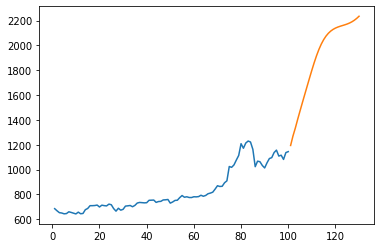

In [ ]:
plt.plot(day_new,scaler.inverse_transform(data1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

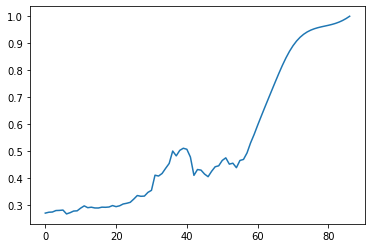

In [ ]:
df1=data1.tolist()
df1.extend(lst_output)
plt.plot(df1[1200:])